In [39]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy import ndimage, sparse, linalg
from skimage.color import label2rgb, rgb2lab
from skimage.feature import local_binary_pattern
import pyrtools as pt
from tqdm import tqdm

from utils import im2double, gauss2D, local_min, get_weights, seg2bmap
from tqdm import tqdm

In [40]:
def get_speed_based_on_gradient(img, normSigma=5):
    [gx,gy] = np.gradient(255*img)
    mag = np.sqrt(gx**2 + gy**2)
    filt = np.array([1])
    filt = filt.reshape((1,-1))
    ss_mag = pt.corrDn(mag, filt,'repeat', step=[2, 2])
    stdev = normSigma
    nTaps = np.round(3*stdev) * 2 + 1
    
    lpImpResp = gauss2D((1,nTaps),stdev)
    lpImpResp = lpImpResp / np.max(lpImpResp)
    smooth_ssmag0 = ndimage.convolve(ss_mag, lpImpResp)
    smooth_ssmag = ndimage.convolve(smooth_ssmag0, lpImpResp.conj().T)

    f = np.array([0.5,1.0,0.5]).conj().T
    f = f.reshape(-1,1)
    res = pt.upConv(smooth_ssmag,f,'reflect1',step=[2,1])
    smooth_mag = pt.upConv(res,f.conj().T,'reflect1',step=[1,2])

    smooth_mag = smooth_mag / (np.sqrt(2*np.pi) * stdev)
    if (smooth_mag.shape[0] != mag.shape[0]):
        smooth_mag = smooth_mag[:-1,:]
    if (smooth_mag.shape[1] != mag.shape[1]):
        smooth_mag = smooth_mag[:,:-1]
    magHalfHeight = 10.0
    normGradMag = 127 * (mag / (magHalfHeight + smooth_mag))
    speed = np.exp(-normGradMag/10)
    Dx= np.exp(normGradMag/10)
    return Dx,speed

def get_seeds_orig(img,num_seeds,speed):
    size_grid = np.sqrt(np.size(img) / num_seeds)
    rows = img.shape[0] / size_grid
    cols = img.shape[1] / size_grid
    size_grid_row = img.shape[0] / math.ceil(rows)
    size_grid_col = img.shape[1] / math.ceil(cols)
    [x,y] = np.mgrid[0:math.ceil(rows-1)+1,0:math.ceil(cols-1)+1]
    x = x.astype(float).T
    y = y.astype(float).T
    y = y*size_grid_col + size_grid_col/2
    x = x*size_grid_row + size_grid_row/2
    
    mag = 1-speed
    
    minDistBetweenSeeds = min(size_grid_row,size_grid_col)
    seedRadius = 1
    
    maxShift = math.floor((minDistBetweenSeeds - 2*seedRadius) / 2) - 1
    N = math.ceil(maxShift/2)
#     size = (2*N, 2*N)
#     shape = cv2.MORPH_RECT
#     kernel = cv2.getStructuringElement(shape, size)
#     min_image = cv2.erode(mag, kernel)
    [dx,dy] = local_min(img,N)
    ind = np.hstack((x.astype("int")[0,:],y.astype("int")[:,0]))
    x_row = list(x[0,:].astype("int")-1)
    y_row = list(y[:,0].astype("int")-1)
    new_x = dx[np.ix_(x_row, y_row)].T
    new_y = dy[np.ix_(x_row, y_row)].T
    x = new_x
    y = new_y
    off = 2
    x_trun = x.copy()
    x_trun[x_trun>(img.shape[0]-off)] = img.shape[0]-off
    y_trun = y.copy()
    y_trun[y_trun>(img.shape[1]-off)] = img.shape[1]-off
    x = x_trun
    x[x<(1+off)] = 1+off
    y = y_trun.copy()
    y[y<(1+off)] = 1+off
    
    seeds = np.vstack((x.flatten(),y.flatten())).T
    return seeds   

def generate_seeds(Nsp,img):
    n_init = np.round(Nsp/4)
    expSuperPixelDist = np.sqrt(np.size(img)/n_init)
    normSigma = math.floor(expSuperPixelDist / 2.5)
    _,speed = get_speed_based_on_gradient(img,normSigma)
#     print ("speed:",speed[0,:])
    seeds = get_seeds_orig(img,n_init,speed)
    return seeds

In [41]:
# Params
Nsp=200 #num of sp
Thres=0.35 #threshold for split
beta=30 #gaussian parameter 
alpha=0.9992 #Lazy parameter
nItrs_max = 10 #limit for the number of iterations


In [42]:
img = cv2.cvtColor(cv2.imread("../images/290.jpg"),cv2.COLOR_BGR2RGB)
scale_percent = 25
width = math.ceil(img.shape[1] * scale_percent / 100)
height = math.ceil(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
gray_img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
orig_img = img.copy()
img = im2double(img)
X,Y,Z = img.shape

In [43]:
seeds = generate_seeds(Nsp,im2double(gray_img/255))
print(seeds[:5])

[[ 4.  4.]
 [22.  5.]
 [35.  5.]
 [45.  5.]
 [62.  6.]]


In [44]:
def LRW(adj, seeds, labels, alpha, size):
    """Find and optimize the superpixel results
    Args:
        adj: The adjacency matrix of the graph generated from image
        seeds: The seed positions (Row major form)
        labels: The labels corrosponding to the seeds
        alpha: Probability of staying put in LRW
        size: Size of the image
    Returns:
        image: Labeled image
        prob: The probability that the seed belongs to the label
    """
#     plt.hist(adj.data)
#     plt.show()
    I = sparse.coo_matrix((np.ones(size), 
                              (np.arange(size), np.arange(size))), 
                              shape=(size, size))
#     print (1./np.array(adj.sum(axis=0)).ravel())
    D_inv = sparse.coo_matrix((1/np.array(adj.sum(axis=0)).ravel(), 
                              (np.arange(size), np.arange(size))), 
                              shape=(size, size))
    D_inv.eliminate_zeros()
    I.eliminate_zeros()
#     print (D_inv.max())
#     plt.hist(D_inv.data)
#     plt.show()
#     np.reciprocal(D_inv.data, out=D_inv.data)
    labels = labels.T
    K = len(labels)
    lines = np.zeros(shape=(size, K))
#     print (seeds)
    for k in range(K):
        label_idx = np.nonzero(labels.flatten() == k)[0]
#         label_idx = np.vstack((r,c))
#         print (label_idx)
        mk = label_idx.shape[0]
        lines[seeds[label_idx.flatten()].astype(int), k] = 1 / mk
    D_inv_sqrt = D_inv.sqrt()
    S = D_inv_sqrt @ adj @ D_inv_sqrt
    new = (I-alpha*S)
    print (lines.shape,new.shape)
    flk = sparse.linalg.spsolve(new, lines)
    likelihoods = np.zeros(shape=(size, len(labels)))
    for k in range(len(labels)):
        likelihoods[:,k] = flk[:,k]/np.sum(flk[:,k])
#     plt.hist(likelihoods.ravel(), bins=100)
    sum_like = 1/np.sum(likelihoods, axis=1)
    probs = sparse.coo_matrix((sum_like, (np.arange(size), np.arange(size)))) @ likelihoods
    labels_idx = probs.argmax(axis=1)
#     plt.hist(labels_idx,bins=np.arange(60))
#     plt.show()
    prob = probs.max(1)
    return prob, labels_idx

def energy_opt(image, seeds, alpha, count, iters, sigma, thres):
    """Find and optimize the superpixel results
    Args:
        image: Original Image (RGB / Grayscale)
        seeds: The initial seed positions
        alpha: Probability of staying put in LRW
        count: Number of superpixels
        iters: Max number of iterations
        sigma: Gaussian parameter
        thres: Threshold to split bigger superpixels
    Returns:
        label: Labeled image
        seeds: The optimized seed positions
        iters: The number of iterations taken for convergence
    """
    pbar = tqdm(total=nItrs_max)
    height, width = image.shape[:2]
    
    lab = rgb2lab(image, illuminant='D65')

    # Generate adjacency matrix
    adj = get_weights(lab, sigma)
    gray_img = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
    LBP = local_binary_pattern(gray_img, 8, 1, 'uniform')#not sure if method should be uniform
    LBP = LBP/np.sum(LBP,axis=0)
#     lbp = lbp.ravel()
#     print (LBP.shape)
    plt.hist(LBP)
    plt.show()
    area_aver=np.sum(np.sum(LBP,axis=0))/count
    
    # Iteratvely improve superpixels
    new_seeds = seeds.copy()
#     print (new_seeds)
    iter_num = 0
    while len(new_seeds) < count and iter_num <= iters:
        # Get labels and seed indices in row major form
        seeds_idx = new_seeds[:,0]*image.shape[1] + new_seeds[:,1]
        labels = np.arange(len(new_seeds))
        prob, labels_idx = LRW(adj, new_seeds, labels, alpha, height*width)
#         break
        # plt.hist(labels_idx, bins = 50)
        label_img = labels_idx.reshape((height, width))
        prob_map = prob.reshape((height, width))
        cmt = 1 - prob_map
        centers_new = np.empty((2,))
        wx_all = np.exp(-(cmt/0.8)) # TODO: replace by phi
        zer_count = 0 #how many seeds have no points assigned - 29 each time. why?
        for k in range(0, len(new_seeds)):
            r,c = np.nonzero(label_img == k)
#             print (tmp)
# #             print (tmp)
            if (len(r)==0 or len(r)==1):
                zer_count+=1
                continue
            cmt_s = cmt[label_img == k]
            wx = wx_all[label_img == k]
            mask = np.tile(new_seeds[k,:], (len(r), 1))
            rc = np.vstack((r,c))
#             print (rc.shape)
            dists = np.sqrt(np.sum(((mask-rc.T)**2),axis = 1))
#             print (cmt_s.shape)
#             print(label_img)
#             print(cmt_s.shape, label_img.shape, k)
#             print(cmt_s.shape)
            idx_centre = (dists == 0)
            cmt_s = np.delete(cmt_s, idx_centre, axis=0)
#             print(cmt_s.shape)
            
#             cmt_s = cmt_s.reshape(-1,1)
            r = np.delete(r, idx_centre, axis=0)
            c = np.delete(c, idx_centre, axis=0)
            dists = np.delete(dists, idx_centre, axis=0)
            wx = np.delete(wx, idx_centre, axis=0)
            mass=np.sum(wx*(cmt_s/dists),axis=0)
#             print (mass.shape)
#             if (mass==0):
#                 cp_new = np.array([np.float("Inf"),np.float("Inf")])
#             else:
            cp_new = np.array([0,0])
#             print ("shape:",(wx*(cmt_s/dists)*r).shape)
            temp1 = np.sum(wx*(cmt_s/dists)*r,axis=0)/mass
            temp2 = np.sum(wx*(cmt_s/dists)*c,axis=0)/mass
            cp_new = np.hstack((temp1,temp2))
#             print (cp_new)
            if np.sqrt(np.sum((np.round(cp_new)-new_seeds[k,:])**2,axis=0))<=1.5:
                print ("Entered if")
                area_l=np.sum(LBP[label_img==k],axis=0) # compute the area of superpixel i
                lbpratio=area_l/area_aver
                if lbpratio>=thres:
                    print ("Entered thres")
                    mask = np.delete(mask,-1,0)
                    M=np.ones((2,2))
                    temp_Cs=cmt_s**2/dists**2
                    crd_diff=np.vstack((r,c)).T-mask
                    M = np.array([[0,0],[0,0]])
                    M[0,0]=np.sum(temp_Cs*crd_diff[:,0]**2,axis=0)
                    M[0,1]=np.sum(temp_Cs*crd_diff[:,0]*crd_diff[:,1],axis=0)
                    M[1,0]=M[0,1]
                    M[1,1]=sum(temp_Cs*crd_diff[:,1]**2)
                    U,_,_ = np.linalg.svd(M)
                    temp_split=crd_diff @ U[:,0]
                    cmt_s = cmt_s.reshape([-1,1])
                    temp_split = temp_split.reshape([-1,1])
                    dists = dists.reshape([-1,1])
#                     print(temp_split.shape, cmt_s.shape, dists.shape)
                    mass1=np.sum(cmt_s[temp_split>0]/dists[temp_split>0],axis=0)
                    mass2=np.sum(cmt_s[temp_split<0]/dists[temp_split<0],axis=0)
                    c1 = np.array([0,0])
                    c2 = np.array([0,0])
                    r = r.reshape([-1,1])
                    c = c.reshape([-1,1])
                    c1[0]=np.sum((cmt_s[temp_split>0]/dists[temp_split>0])*r[temp_split>0],axis=0)/mass1
                    c1[1]=np.sum((cmt_s[temp_split>0]/dists[temp_split>0])*c[temp_split>0],axis=0)/mass1
                    c2[0]=np.sum((cmt_s[temp_split<0]/dists[temp_split<0])*r[temp_split<0],axis=0)/mass2
                    c2[1]=np.sum((cmt_s[temp_split<0]/dists[temp_split<0])*c[temp_split<0],axis=0)/mass2
#                     np.hstack((x,y))
                    centers_new=np.vstack((centers_new, c1))
                    centers_new=np.vstack((centers_new, c2))
                else:
                    centers_new=np.vstack((centers_new, cp_new))
            else:
#                 centers_new = centers_new.reshape(cp_new.shape)
                centers_new=np.vstack((centers_new, cp_new))
        
            # print(cp_new1, cp_new2, mass)
#             print(tmp)
#             r = [l[0] for l in tmp]
#             c = [l[1] for l in tmp]
#         print (centers_new)
        new_seeds=np.round(centers_new)
#         print (new_seeds.shape)
        iter_num += 1
        pbar.update(1)
    seeds_idx = new_seeds[:,0]*width + new_seeds[:,1]
    labels = np.arange(len(new_seeds))
    prob, labels_idx = LRW(adj, new_seeds, labels, alpha, height*width)
    label_img = labels_idx.reshape((height, width))
#         print(new_seeds, iter_num)
    return label_img, new_seeds, iter_num




  0%|          | 0/10 [00:00<?, ?it/s]

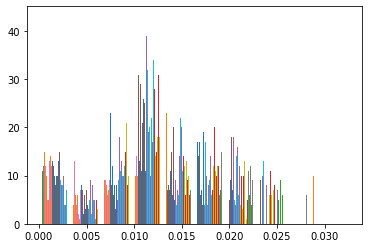

(9801, 54) (9801, 9801)



 20%|██        | 2/10 [00:02<00:07,  1.10it/s]

(9801, 21) (9801, 9801)
Entered if
Entered thres
(9801, 19) (9801, 9801)



 40%|████      | 4/10 [00:02<00:02,  2.44it/s]

Entered if
Entered if
(9801, 17) (9801, 9801)
Entered if
Entered if
Entered if
Entered thres
Entered if
Entered thres
Entered if
Entered thres
(9801, 19) (9801, 9801)



 50%|█████     | 5/10 [00:02<00:01,  2.98it/s]

Entered if
Entered if
Entered if
Entered if
Entered thres
Entered if
Entered thres
Entered if
Entered thres
Entered if
Entered thres
(9801, 21) (9801, 9801)



 60%|██████    | 6/10 [00:02<00:01,  3.45it/s]

Entered if
Entered if
Entered if
Entered thres
(9801, 21) (9801, 9801)
Entered if
Entered if
Entered if
Entered thres


 70%|███████   | 7/10 [00:03<00:00,  3.83it/s]


Entered if
Entered thres
Entered if
Entered thres
Entered if
Entered thres
Entered if
Entered thres
(9801, 25) (9801, 9801)



 80%|████████  | 8/10 [00:03<00:00,  4.07it/s]

Entered if
Entered if
Entered if
Entered thres
Entered if
Entered thres
Entered if
Entered thres
Entered if
Entered if
Entered thres
Entered if
(9801, 26) (9801, 9801)



 90%|█████████ | 9/10 [00:03<00:00,  4.27it/s]

Entered if
Entered if
Entered if
Entered thres
Entered if
Entered if
Entered thres
Entered if
Entered if
Entered thres
(9801, 25) (9801, 9801)



100%|██████████| 10/10 [00:03<00:00,  4.27it/s]

Entered if
Entered thres
Entered if
Entered if
Entered thres
Entered if
Entered if
(9801, 24) (9801, 9801)



11it [00:03,  4.41it/s]                        

Entered if
Entered if
Entered if
Entered if
Entered thres
Entered if
Entered thres
Entered if
Entered if
Entered if
Entered thres
Entered if
Entered if
Entered thres
Entered if
Entered thres
(9801, 26) (9801, 9801)


11it [00:04,  2.65it/s]


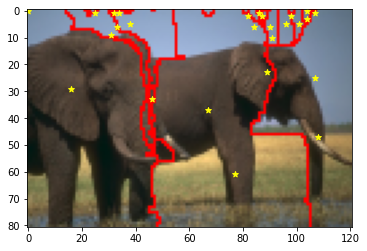

In [45]:
res, seeds, iters = energy_opt(orig_img, seeds, alpha, Nsp, nItrs_max, beta, Thres)
# print (seeds)
bmap = seg2bmap(res,Y,X)
idx = np.nonzero(bmap>0)

bmapOnImg = img
temp = img[:,:,0]
temp[idx] = 1
bmapOnImg[:,:,0] = temp
if Z==3:
    temp=img[:,:,1]
    temp[idx]=0
    bmapOnImg[:,:,1] = temp
    temp=img[:,:,2]
    temp[idx]=0
    bmapOnImg[:,:,2] = temp

## vis bmaponimg
plt.imshow(bmapOnImg)
seeds_x = [i[0] for i in seeds]
seeds_y = [i[1] for i in seeds]
plt.scatter(seeds_y,seeds_x,color="yellow",marker="*")
plt.show()

In [36]:
seeds.shape

(26, 2)

In [37]:
Thres

0.35

In [38]:
unique, counts = np.unique(res, return_counts=True)
unique, counts

(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 22, 23, 24, 25]),
 array([3364,  219,    6,    1,    1,   14,    4,  403,   76, 3648,    4,
          16,    2,    6,   42,    4,    1,   61,   75,   16,    3, 1824,
          11]))